In [8]:
# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon, ttest_rel

CV_PATHS = {
    "ElasticNet": {
        "cv5": "01_simple_baselines/results/elastic_net/voom_30_pcs_tissue_growth.csv",
        "cv10": "01_simple_baselines/results/elastic_net/10_fold_voom_30_pcs_tissue_growth.csv",
    },
    "RandomForest": {
        "cv5": "02_complex_baselines/results/rf/voom_30_pcs_tissue_growth.csv",
        "cv10": "02_complex_baselines/results/rf/10_fold_voom_30_pcs_tissue_growth.csv",
    }
}

def load_cv(path, model, cvtag):
    df = pd.read_csv(path)
    df["Model"] = model
    df["CV"] = cvtag
    # normalize columns
    df.rename(columns=lambda c: c.strip().replace("²", "^2"), inplace=True)
    if "r2_mean" not in df.columns and "r2_global" in df.columns:
        df = df.rename(columns={"r2_global": "r2_mean", "rmse": "rmse_mean"})
    return df[["DRUG_ID","n_samples","r2_mean","rmse_mean","Model","CV"]]

frames = []
for model, paths in CV_PATHS.items():
    for cvtag, path in paths.items():
        frames.append(load_cv(path, model, cvtag))

cv_df = pd.concat(frames, ignore_index=True)
print("✅ combined:", cv_df.shape)
cv_df.head()


✅ combined: (2778, 6)


,DRUG_ID,n_samples,r2_mean,rmse_mean,Model,CV
0,1,384,0.063932,1.064624,ElasticNet,cv5
1,3,350,0.038101,1.938471,ElasticNet,cv5
2,5,387,0.143765,1.518072,ElasticNet,cv5
3,6,396,-0.019283,0.885369,ElasticNet,cv5
4,9,390,0.064954,1.398826,ElasticNet,cv5


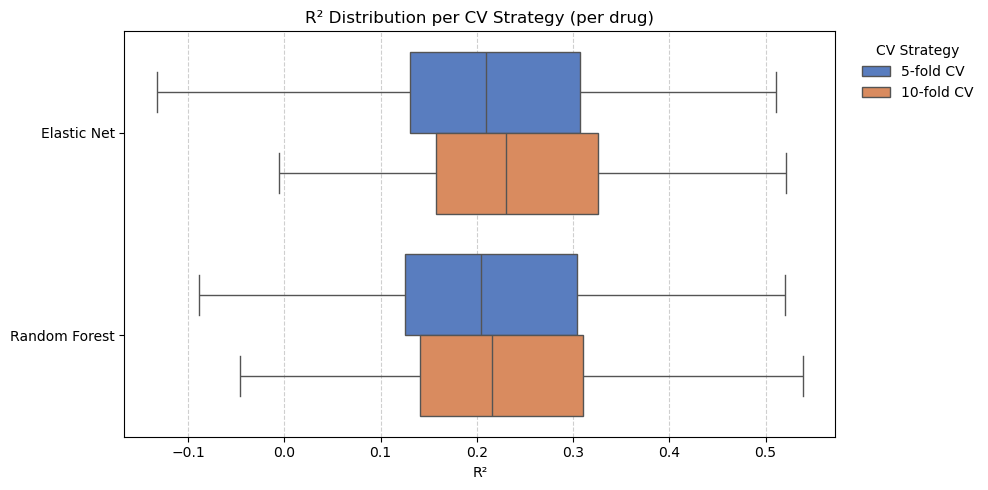

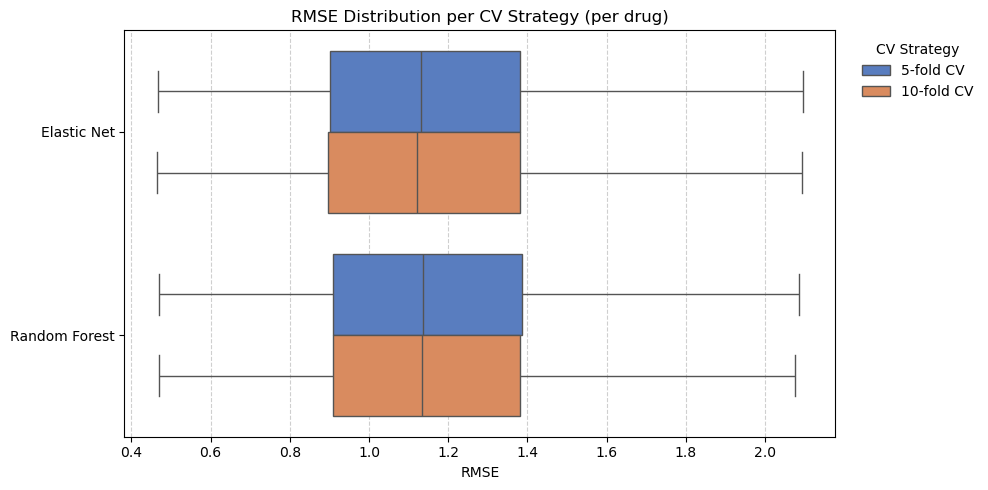

In [16]:
# %%
pretty_map = {"ElasticNet":"Elastic Net","RandomForest":"Random Forest"}
cv_map = {"cv5":"5-fold CV","cv10":"10-fold CV"}

df_plot = cv_df.copy()
df_plot["ModelPretty"] = df_plot["Model"].map(pretty_map)
df_plot["CVPretty"] = df_plot["CV"].map(cv_map)

# %%
# --- R² ---
plt.figure(figsize=(10,5))
sns.boxplot(
    data=df_plot,
    x="r2_mean", y="ModelPretty",
    hue="CVPretty", palette="muted",
    showfliers=False, dodge=True
)
plt.title("R² Distribution per CV Strategy (per drug)")
plt.xlabel("R²"); plt.ylabel("")
plt.grid(axis="x", linestyle="--", alpha=0.6)

# move legend outside
plt.legend(
    title="CV Strategy", frameon=False,
    bbox_to_anchor=(1.02, 1), loc="upper left"
)
plt.tight_layout(); plt.show()

# --- RMSE ---
plt.figure(figsize=(10,5))
sns.boxplot(
    data=df_plot,
    x="rmse_mean", y="ModelPretty",
    hue="CVPretty", palette="muted",
    showfliers=False, dodge=True
)
plt.title("RMSE Distribution per CV Strategy (per drug)")
plt.xlabel("RMSE"); plt.ylabel("")
plt.grid(axis="x", linestyle="--", alpha=0.6)

plt.legend(
    title="CV Strategy", frameon=False,
    bbox_to_anchor=(1.02, 1), loc="upper left"
)
plt.tight_layout(); plt.show()


In [10]:
# %%
def paired_cv_tests(df_model, metric="r2_mean"):
    wide = df_model.pivot_table(index="DRUG_ID", columns="CV", values=metric, aggfunc="mean").dropna()
    if wide.empty: 
        return None
    x, y = wide["cv10"], wide["cv5"]
    d = x - y if metric=="r2_mean" else y - x   # positive = 10-fold better
    n = len(d)
    return {
        "n": n,
        "delta_mean": d.mean(),
        "delta_median": d.median(),
        "win_rate": (d > 0).mean(),
        "wilcoxon_p": wilcoxon(d, zero_method="pratt").pvalue if n>=5 else np.nan,
        "ttest_p": ttest_rel(x, y, nan_policy="omit").pvalue if n>=5 else np.nan
    }

rows = []
for model in ["ElasticNet","RandomForest"]:
    df_m = cv_df[cv_df["Model"]==model]
    out_r2 = paired_cv_tests(df_m, "r2_mean")
    out_rmse = paired_cv_tests(df_m, "rmse_mean")
    if out_r2: rows.append({"Model":model,"Metric":"R²",**out_r2})
    if out_rmse: rows.append({"Model":model,"Metric":"RMSE (lower better)",**out_rmse})

cv_summary = pd.DataFrame(rows)
display(cv_summary)


,Model,Metric,n,delta_mean,delta_median,win_rate,wilcoxon_p,ttest_p
0,ElasticNet,R²,692,0.020950,0.017587,0.917630,1.857015e-101,1.204406e-77
1,ElasticNet,RMSE (lower better),692,0.007725,0.006353,0.781792,4.610149e-57,5.860093e-42
2,RandomForest,R²,692,0.011689,0.009831,0.767341,1.617853e-60,1.955902e-49
3,RandomForest,RMSE (lower better),692,0.000873,0.001193,0.560694,5.039399e-02,3.182045e-02


In [11]:
# %%
def agg_stats(df, metric):
    g = (
        df.groupby(["ModelPretty","CVPretty"], as_index=False)[metric]
          .agg(mean="mean", std="std", n="count")
    )
    g["se"] = g["std"] / np.sqrt(g["n"])
    g["ci95"] = 1.96 * g["se"]
    g["metric"] = metric
    return g

stats_r2 = agg_stats(df_plot, "r2_mean")
stats_rmse = agg_stats(df_plot, "rmse_mean")

summary_table = pd.concat([stats_r2, stats_rmse], ignore_index=True)
summary_table = summary_table.rename(columns={
    "mean":"Mean", "std":"Std", "n":"N", "ci95":"95% CI"
})

display(summary_table[["metric","ModelPretty","CVPretty","N","Mean","Std","95% CI"]].round(4))


,metric,ModelPretty,CVPretty,N,Mean,Std,95% CI
0,r2_mean,Elastic Net,10-fold CV,692,0.2400,0.1100,0.0082
1,r2_mean,Elastic Net,5-fold CV,697,0.2179,0.1155,0.0086
2,r2_mean,Random Forest,10-fold CV,692,0.2267,0.1164,0.0087
3,r2_mean,Random Forest,5-fold CV,697,0.2137,0.1206,0.0090
4,rmse_mean,Elastic Net,10-fold CV,692,1.1612,0.3496,0.0260
5,rmse_mean,Elastic Net,5-fold CV,697,1.1693,0.3506,0.0260
6,rmse_mean,Random Forest,10-fold CV,692,1.1698,0.3488,0.0260
7,rmse_mean,Random Forest,5-fold CV,697,1.1712,0.3488,0.0259
